<center>
    <img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800"> 
</center>  

# Yet another math for DS course: домашнее задание 7

**ФИО:** Теплов Вячеслав Сергеевич \
**Любимый анекдот:** \
Мама собирает сына в школу: \
— Вот, я тебе положила хлеб, колбасу и гвозди. \
— Мама, зачем?! \
— Ну как же… Берешь хлеб, кладешь на него колбасу и ешь. \
— А гвозди? \
— Так вот же они!

__Жёсткий дедлайн:__ 23:59MSK 24.11.2024

## Формат сдачи

Сам ноутбук называйте в формате hw-07-USERNAME.ipynb, где USERNAME — ваши фамилия и имя. Файл надо будет сдать в anytask.

## Задача №1: 50 оттенков градиентного спуска (10 баллов)

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Для наших целей будем использовать искуственно сгенерированные данные.

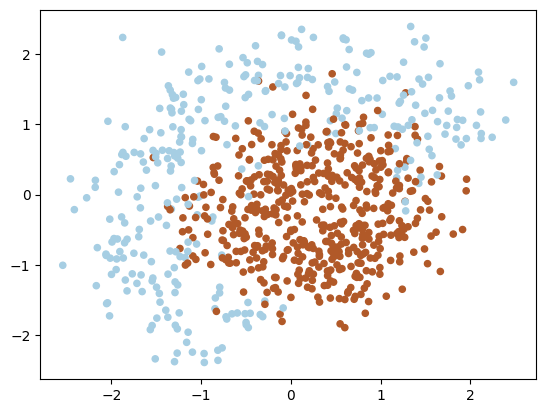

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

__[1 балл]__ Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """

    feature0 = X[:, 0]
    feature1 = X[:, 1]
    feature0_squared = feature0 ** 2
    feature1_squared = feature1 ** 2
    feature0_feature1 = feature0 * feature1

    expanded_X = np.column_stack((feature0, feature1, feature0_squared, feature1_squared, feature0_feature1, np.ones(X.shape[0])))
    
    return expanded_X
    

__[1 балл]__ Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [5]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    return 1 / (1 + np.exp(-np.dot(X, w)))

__[1 балл]__ Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [6]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """

    probabilities = probability(X, w)
    loss = -np.mean(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))
    
    return loss

__[2 балла]__ Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell [\sigma(\langle w, x \rangle) - y_i]x_i$$

In [7]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """

    probabilities = probability(X, w)
    error = probabilities - y
    grad = np.dot(X.T, error) / len(y)
    
    return grad

Функция ниже предназначена для визуализации процесса обучения. 

In [8]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

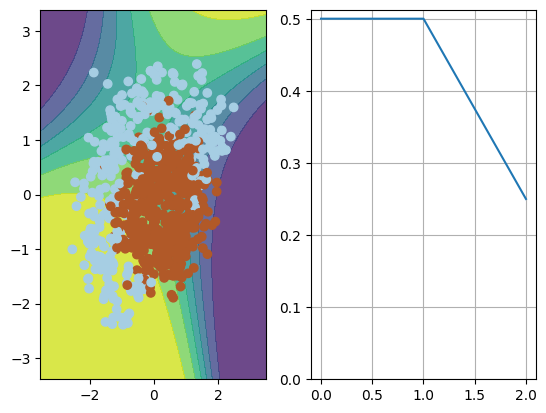

In [9]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

#### __[2 балла]__ Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$

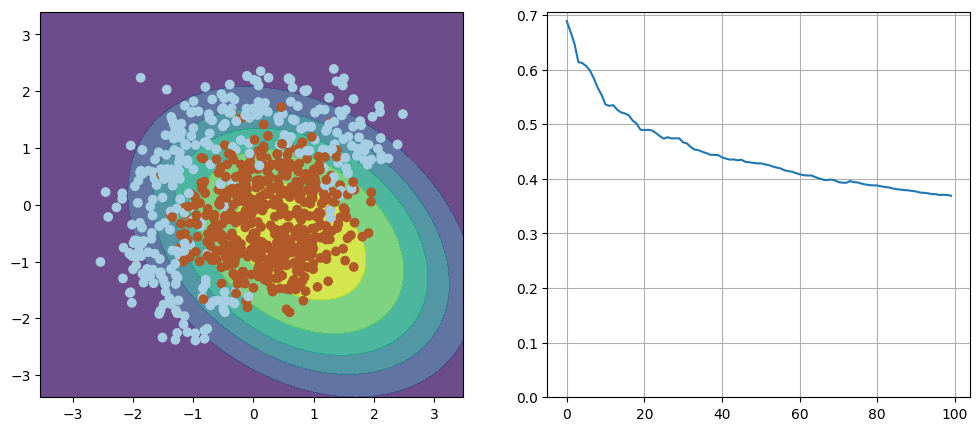

<Figure size 640x480 with 0 Axes>

In [15]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05
alpha = 0.9
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(expand(X[indices]), y[indices], w)
    w = w - eta * grad
    loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

#### __[1 балл]__ Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


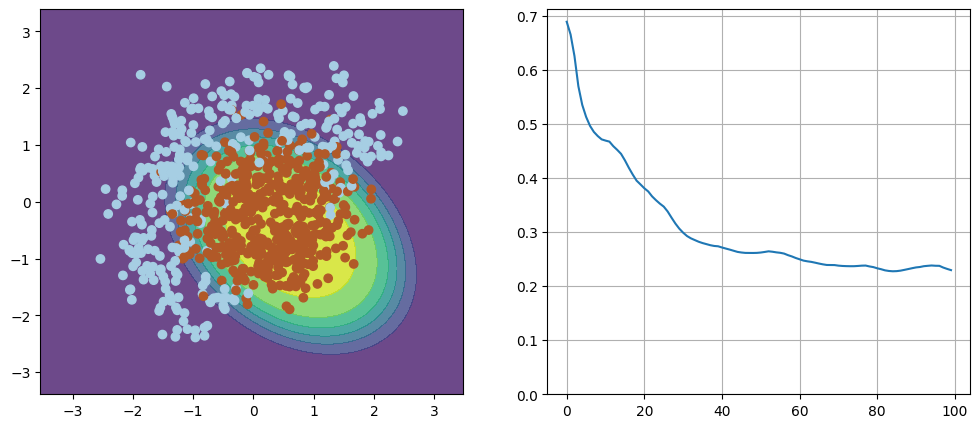

<Figure size 640x480 with 0 Axes>

In [16]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(expand(X[indices]), y[indices], w)
    nu = alpha * nu + eta * grad
    w = w - nu

    loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

#### __[1 балл]__ RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

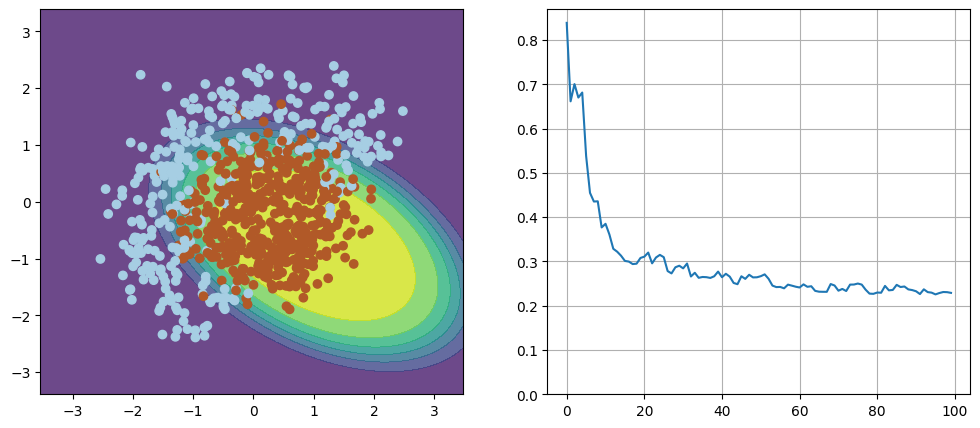

<Figure size 640x480 with 0 Axes>

In [17]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1
alpha = 0.9
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(expand(X[indices]), y[indices], w)
    g2 = alpha * g2 + (1 - alpha) * grad**2
    w = w - eta / (np.sqrt(g2) + eps) * grad

    loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

__[1 балл]__ Реализуйте Adam

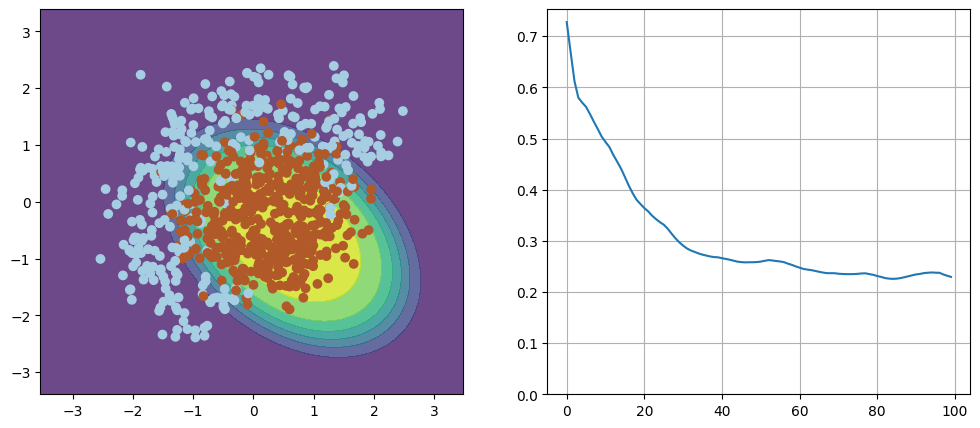

<Figure size 640x480 with 0 Axes>

In [21]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

m = np.zeros_like(w)
v = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(expand(X[indices]), y[indices], w)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad**2)
    m_1 = m / (1 - beta1 ** (i + 1))
    v_1 = v / (1 - beta2 ** (i + 1))
    w = w - eta * m_1 / (np.sqrt(v_1) + eps)

    loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

__[бонусные 2]__ Выясните что такое метод Ньютона (метод второго порядка) и реализуйте его.

In [ ]:
# your code here
# ༼ つ ಥ_ಥ ༽つ

__[бонусные 2]__ Выясните, что такое weight decay и реализуйте его для базовой версии SGD. Правда ли, что эта модернизация улучшает обучение?

In [ ]:
# your code here
# ( ￣ー￣)